In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import pi
from scipy.stats import unitary_group
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit

In [3]:
def create_CB_circ(nqubits, theta):
        
    """
    Creates a parametrized CB circuit
    
    Args:  
        nqubits: int
                 number of qubits
        theta: numpy array
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    p = len(theta) // (4 * (nqubits // 2) * 2)          # numbers of layers
    qc = QuantumCircuit(nqubits)
    
    for i in range(p):
        alpha = theta[0::4]
        beta = theta[1::4]
        gamma = theta[2::4]
        zeta = theta[3::4]
      
    
    if nqubits % 2 == 0:
        
        pairs = []                #set of pairs

        for i in range(nqubits):
            if i % 2 == 0:
                pairs.append((i, (i + 1) % nqubits))
        for i in range(nqubits):
            if i % 2 == 1:
                pairs.append((i, (i + 1) % nqubits))


        for irep in range(p * nqubits):    # one irep creats one block
            if irep % nqubits == 0:
                qc.barrier()
            i, j = pairs[irep % nqubits]
            qc.rx(alpha[irep], i)
            qc.rx(beta[irep], j)
            qc.cx(i, j)
            qc.rz(gamma[irep], i)
            qc.rz(zeta[irep], j)

                
    if nqubits % 2 == 1:
        
        pairs = []                #set of pairs

        for i in range(nqubits):
            if (i % 2 == 0) and (i != nqubits - 1):
                pairs.append((i, (i + 1) % nqubits))
        for i in range(nqubits):
            if i % 2 == 1:
                pairs.append((i, (i + 1) % nqubits))


        for irep in range(p * (nqubits - 1)):    # one irep creats one block
            if irep % (nqubits - 1) == 0:
                qc.barrier()
            i, j = pairs[irep % (nqubits - 1)]
            qc.rx(alpha[irep], i)
            qc.rx(beta[irep], j)
            qc.cx(i, j)
            qc.rz(gamma[irep], i)
            qc.rz(zeta[irep], j)        

    return qc



In [4]:
def outputstate(theta, nqubits):
    """
    Prepare state
    
    Args: 
        theta: numpy array
                array of parameters
        nqubits: int
                number of qubits
            
    Returns:
        state: numpy array
                prepared state
    
    """
    
    backend = Aer.get_backend('statevector_simulator')
    qc = create_CB_circ(nqubits, theta)
    
    job = backend.run(qc)
    result = job.result()
    state = result.get_statevector(qc).data

    return state


In [5]:
def energy(theta, H, nqubits):
    
    """
    Compute enery
    
    Args:
        theta: numpy array
                array of parameters
        H: numpy array
            Telescope hamiltonian
        nqubits: int
            number of qubits
            
     Returns:
         E: int
             energy
    """
    
    state = outputstate(theta, nqubits)
    
    return np.real(np.dot(state.conj(), np.dot(H, state)) )


In [6]:
def ising_1D_1R(nqubits, J_array, h_array):
    
    """
    Obtain transvers field ising hamiltonian 
    
    Args: 
        nqubits: int
                number of particles
        h: int
                transverse field strength 
                
     Returns:
         H: numpy array
                hamiltonian
    """

    edges = np.zeros((nqubits - 1, 2)) 

    for i in range(nqubits - 1):
        edges[i][0] = i + 1
        edges[i][1] = i + 2
      
            
    H = np.zeros((2**nqubits, 2**nqubits))
    Z = np.array([[1, 0], 
                  [0, -1]])
    I = np.array([[1, 0], 
                  [0, 1]])  
    X = np.array([[0, 1],
                  [1, 0]])
    
    for n in range(len(edges)):
        for edge in edges:  # run edges
            tmp = 1

            for i in range(1, nqubits + 1):
                if i == edge[0] or i == edge[1]:
                    tmp = np.kron(tmp, Z) 
                else:
                    tmp = np.kron(tmp, I) 

            H += tmp * J_array[n]

            
    for i in range(nqubits):
        tmp_X = 1
        for j in range(nqubits):
            if j == i:
                tmp_X = np.kron(tmp_X, X) 
            else:
                tmp_X = np.kron(tmp_X, I) 
        
        H += tmp_X * h_array[i]
        
    return H


In [7]:
def theta_for_ground_state(nqubits, p, H):
    
    E_min = 1000
    for _ in range(2):
        
        init = np.random.uniform(0, 2 * pi, size=4 * p * (nqubits // 2) * 2)    #initial guess of parameters
        res = minimize(energy, init, args=(H, nqubits), method='L-BFGS-B', options={'gtol': 1e-06, 'maxiter': 100})
        
        if res.fun < E_min:
            E_min = res.fun
            theta = res.x
        
    return np.real(theta)


In [8]:
def func(x, a, b):
    return a * x**b

In [9]:
nqubits = 4                #number of qubits
p = 5                      #number of layers
hamiltonian_number = 100 #number of randon theta star

steps = 100
max_sigma = 0.1

delta_theta_number = 10

In [9]:
# create hamiltonians and obtain optimal parameters

for i in range(hamiltonian_number):    
    
    J_array = np.random.uniform(0, 1, size=(nqubits - 1))
    h_array = np.random.uniform(0, 1, size=nqubits)
    
    H = ising_1D_1R(nqubits, J_array, h_array)
    with open('/home/dima/notebook/Noise/Stochastic perturbation/'+str(i)+'H.csv', 'wb') as f:
        np.save(f, H) 
        
        
    theta = theta_for_ground_state(nqubits, p, H)
    with open('/home/dima/notebook/Noise/Stochastic perturbation/'+str(i)+'theta.csv', 'wb') as f:
        np.save(f, theta) 
        

In [10]:
#obrain energy shift

for i in range(hamiltonian_number): 
    
    with open('/home/dima/notebook/Noise/Constant perturbation/'+str(i)+'H.csv', 'rb') as f:
        H = np.load(f, allow_pickle=True)
        
    with open('/home/dima/notebook/Noise/Constant perturbation/'+str(i)+'theta.csv', 'rb') as f:
        theta = np.load(f)
        
        
    E = np.array([])
    
    for sigma in np.linspace(0, max_sigma, steps):
        
        E_array = np.array([])
        for _ in range(delta_theta_number):
            
            delta_array = np.random.uniform(-sigma, sigma, size=(4  * p * (nqubits // 2) * 2))

            theta_pert = theta + delta_array

            E_array = np.append(E_array, energy(theta_pert, H, nqubits))
        
        E_mean = np.mean(E_array, axis=0)
        
        E = np.append(E, E_mean)

    
    with open('/home/dima/notebook/Noise/Stochastic perturbation/'+str(i)+'E.csv', 'wb') as f:
        np.save(f, E) 
        
    

In [11]:
#average 

E_array = np.array([])

for i in range(hamiltonian_number):
    with open('/home/dima/notebook/Noise/Stochastic perturbation/'+str(i)+'E.csv', 'rb') as f:
        E = np.load(f)
        #print(E)
    E_array = np.concatenate((E_array, E - np.min(E)))

    
E_array = E_array.reshape((hamiltonian_number, steps))

E_mean = np.mean(E_array, axis=0)
E_std = np.std(E_array, axis=0)


In [12]:
#fitting

popt, pcov = curve_fit(func, np.linspace(0, max_sigma, steps), E_mean)

perr = np.sqrt(np.diag(pcov))  #compute one standard deviation errors on the parameters 
popt

array([49.72645208,  1.96653638])

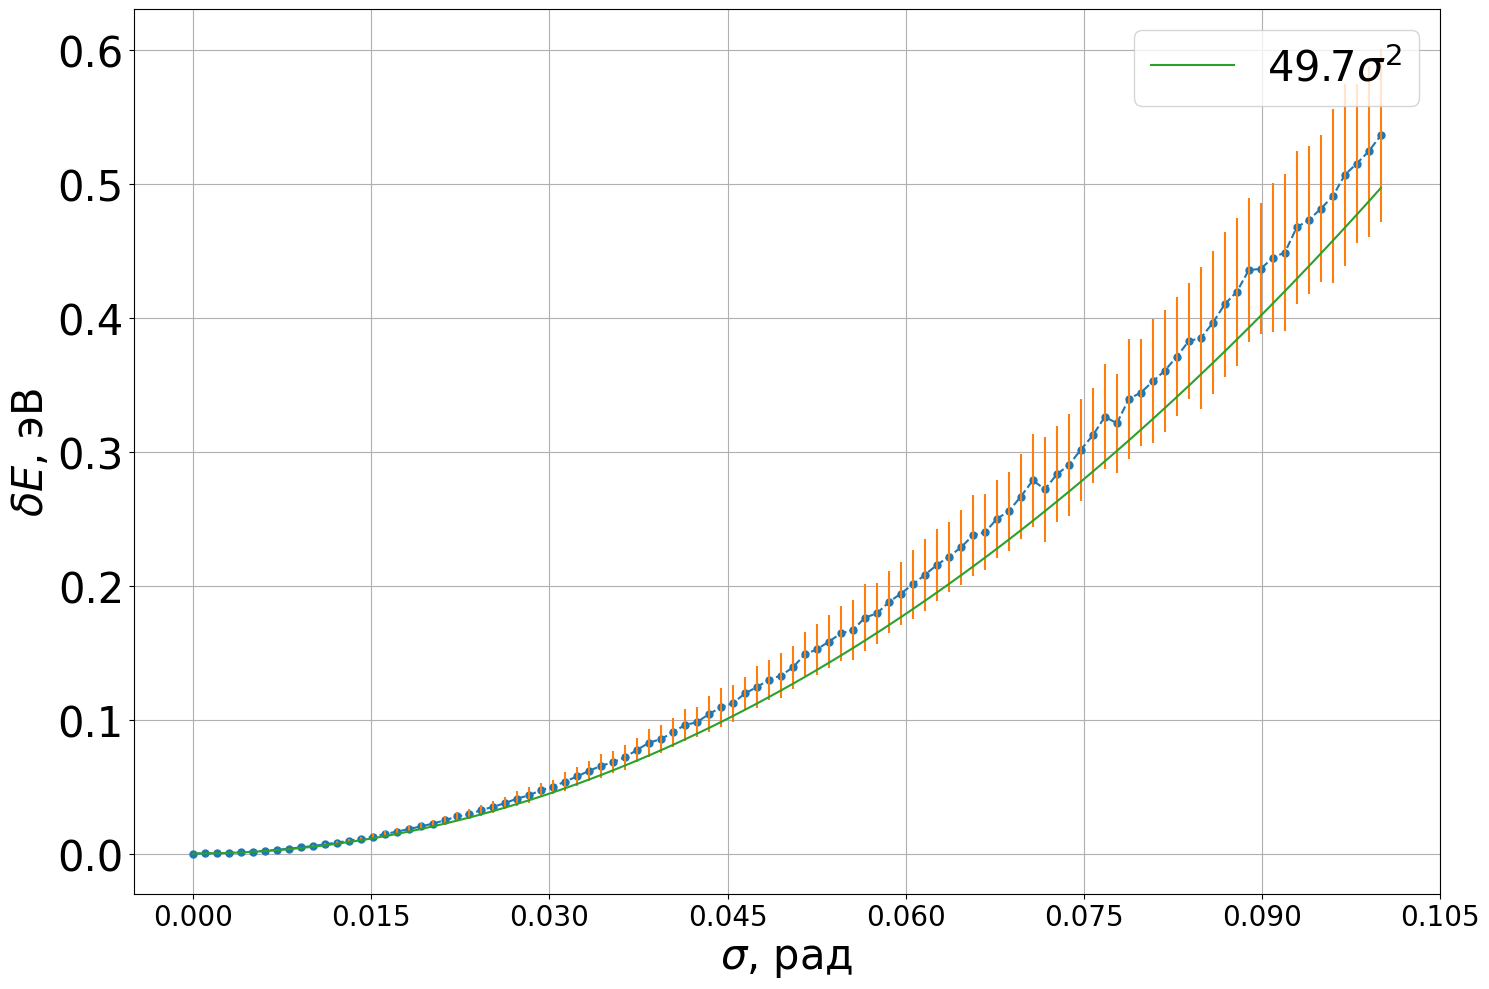

In [15]:
f,ax1 = plt.subplots(1,figsize = (15,10))

ax1.plot(np.linspace(0, max_sigma, steps), E_mean, '.--',markersize=10 )
ax1.errorbar(np.linspace(0, max_sigma, steps), E_mean, E_std, linestyle='None')

ax1.plot(np.linspace(0, max_sigma, steps), [func(x, popt[0], 2) for x in np.linspace(0, max_sigma, steps)], '-',markersize=10, label='$49.7 \sigma^2$')


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('$\sigma$, рад', fontsize = 30 )
ax1.set_ylabel('$\delta E$, эВ', fontsize = 30 )

ax1.legend(fontsize = 30)


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()
plt.savefig('Stochastic perturbation.pdf')


In [22]:
perr

array([0.31600214, 0.0046779 ])